<a href="https://colab.research.google.com/github/ewu2023/CS589-HW4/blob/main/CS589_NeuralNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Packages

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# For reading/writing to files
import json
import csv
import re

# Define Neural Network Class

In [54]:
class NeuralNetwork():
    def __init__(self, networkShape, trainData: pd.DataFrame, classLabels, weights=None, regParam=0, alpha=0.01, epsilon=0.01, debugFlag=False):
        """
        Constructor for the neural network class.
        
        networkShape: A list of integers that contains the number of neurons to use in each layer

        trainData: The data set that will be used to train the model

        weights: A list of weight matrices for each hidden layer. If initialized to None, the constructor will assign random weights
        """

        """
        Process training data
        """
        self.trainData = trainData.sample(frac=1)
        
        # Get a copy of the training data without the labels
        self.noLabelTrainData = trainData.loc[:, ~trainData.columns.isin(classLabels)]
        self.classLabels = classLabels

        # Encode class vectors
        self.classVectors = {}
        for i in range(len(trainData)):
            # Get current row from training data
            row = trainData.iloc[i]

            # Iterate over all classes and assign values
            classVector = {}
            for label in classLabels:
                expVal = row[label]
                classVector[label] = [expVal]

            # Convert class vector to numpy array
            classVecDf = pd.DataFrame(classVector)

            # Append class vector to dictionary of vectors
            # Implementation uses column vectors, so we take transpose here
            self.classVectors[i] = (classVecDf.to_numpy()).T

        self.networkShape = networkShape

        # Set the value of the regularization parameter
        self.regParam = regParam

        # Set the step size for gradient descent
        self.alpha = alpha

        # Set value of epsilon for stopping condition
        self.epsilon = epsilon

        # Set debug flag to show output of intermediate computations
        self.debugFlag = debugFlag

        # Instance variable storing weight matrices
        self.layers = []
        
        # Initialize layers
        for i in range(len(networkShape) - 1):
            # Get the number of neurons in the current and next layers
            numCurLayer = networkShape[i] + 1 # Account for neurons + bias term in current layer
            numNextLayer = networkShape[i + 1]

            # Initialize matrix for the current layer
            # Number of rows = number of neurons in layer i + 1
            # Number of columns = number of neurons in layer i
            layerMatrix = np.zeros(shape=(numNextLayer, numCurLayer))
            if weights:
                layerMatrix = weights[i]
            else:
                self._init_matrix(layerMatrix)
            
            # Append current layer to the list of layers
            self.layers.append(layerMatrix)
        
    def _init_matrix(self, matrix: np.ndarray):
        rows, cols = matrix.shape
        for i in range(rows):
            for j in range(cols):
                matrix[i, j] = norm.rvs()
    
    # Definition for the sigmoid function
    def sigmoid(self, x):
        return (1 / (1 + np.exp(-x)))
    
    # Compute activation vector
    def compute_activation_vector(self, weightedSums: np.ndarray):
        numRows, numCols = weightedSums.shape
        activationVector = np.zeros(shape=(numRows, numCols))

        for i in range(numRows):
            # Get weighted sum from i-th row
            x = weightedSums[i, 0]

            # Compute output of sigmoid function and place it in activation vector
            activationVector[i, 0] = self.sigmoid(x)
        
        return activationVector
    
    # Method for propagating forward one instance
    def propagate_one(self, instance, activations=None, printOut=False):
        # Add a bias term to the instance
        instanceAsNP = instance.to_numpy()
        instanceVector = np.concatenate(([1], instanceAsNP))
        
        # Make instance vector a column vector
        instanceVector = np.atleast_2d(instanceVector).T
        
        # Iterate over each layer and compute activations for each neuron
        prevActivation = instanceVector # Keep track of the activation vector for previous layer

        if activations != None: # If activations is not None, append current activation
            activations.append(prevActivation)

        # If the debug flag was set, print out the first instance vector
        if printOut:
            print(f"Value of a0:\n{prevActivation}\n")

        for i in range(len(self.layers) - 1):
            # Get current weight matrix
            curTheta = self.layers[i]

            # Compute weighted sum vector (z-matrix): Theta^{l=i-1} * a^{l=i-1}
            z = np.matmul(curTheta, prevActivation)

            # Compute activation vector of current layer
            curActivationVec = self.compute_activation_vector(z)
            
            # Add bias term to current activation vector
            curActivationVec = np.concatenate(([[1]], curActivationVec)) # Prepend 1 to vector

            # Update previous activation vector
            prevActivation = curActivationVec

            # Append current activation to list
            if activations != None:
                activations.append(curActivationVec)

            # Print results of computation at this step if debug flag is on
            if printOut:
                print(f"Value of z{i + 1}:\n{z}")
                print(f"Value of a{i + 1}:\n{curActivationVec}\n")
        
        # Compute activation at the final layer
        lastTheta = self.layers[len(self.layers) - 1]
        lastZMat = np.matmul(lastTheta, prevActivation)
        outputVector = self.compute_activation_vector(lastZMat)

        # If the debug flag was set, print results of this final computation
        if printOut:
            print(f"Value of z{len(self.layers)}:\n{lastZMat}")
            print(f"Value of a{len(self.layers)}:\n{outputVector}\n")

        if activations != None:
            activations.append(outputVector)

        # Return as a vector in the event there are multiple outputs
        return outputVector

    # Compute error for an individual output of the neural network
    def compute_one_instance_err(self, expVal, predVal):
        return -expVal * np.log(predVal) - (1 - expVal) * np.log(1 - predVal)

    # Helper method for computing regularized error
    def compute_error(self, df:pd.DataFrame, printOut=False):
        # Keep track of total error across all training instances
        totalErr = 0

        # Iterate over all training instances
        for i in range(len(df)):
            # Get current instance and perform forward propagation on it
            curInstance = df.iloc[i]
            predVector = self.propagate_one(curInstance, printOut=False) # Will be a vector
            # Get the expected values vector
            expVector = self.classVectors[i]

            # Compute error vector
            vectorizedErrorFunc = np.vectorize(self.compute_one_instance_err)
            errVector = vectorizedErrorFunc(expVector, predVector)

            if printOut:
                print(f"Cost associated with Instance {i}: {np.sum(errVector)}\n")
            # Sum all elements of error vector, then add it to total error
            totalErr += np.sum(errVector)
        
        # Compute average error
        avgErr = totalErr / len(df)

        """ Compute the squared sum of all weights in the network """
        weightSqSum = 0
        for weightMatrix in self.layers:
            # Square all of the weights
            squaredMatrix = np.multiply(weightMatrix, weightMatrix)

            # Drop bias terms from squared matrix
            rows, cols = squaredMatrix.shape
            zeroColumn = np.zeros(rows)
            squaredMatrix[:, 0] = zeroColumn

            # Add all columns, then add each column's total to get the total sum for this matrix
            colSums = np.sum(squaredMatrix, axis=0)
            matrixTotal = np.sum(colSums)

            # Add matrix total to sum of the weights squared
            weightSqSum += matrixTotal
        
        # Regularize error
        weightSqSum *= (self.regParam / (2 * len(df)))

        # Return error + regularization term
        return avgErr + weightSqSum
    
    def process_batch(self, startIndex, endIndex):
        # Initialize gradients for each layer
        # Accumulate the gradients in this list
        gradients = []
        for layer in self.layers:
            # Get the shape of each layer
            rows, cols = layer.shape
            gradients.append(np.zeros(shape=(rows,cols)))
        
        for i in range(startIndex, endIndex):
            if self.debugFlag:
                print(f"--- Propagating Instance {i} ---\n")

            # Propagate current instance through the network
            curInstance = self.noLabelTrainData.iloc[i]
            activations_i = []
            self.propagate_one(curInstance, activations=activations_i, printOut=self.debugFlag)

            # Compute delta values for output layer
            outputVector = activations_i[len(activations_i) - 1]
            if self.debugFlag:
                print(f"Instance {i} Activation: {outputVector.T}\n")

            expectedVector = self.classVectors[i]

            delta_vectors = []
            delta_vectors.append(outputVector - expectedVector)

            # Iterate over each layer and compute delta values
            for k in range(len(self.layers) - 1, 0, -1):
                # Get current weight matrix
                weightMatrix = self.layers[k]
                delta_next = delta_vectors[0]

                # Compute delta values for nodes in current layer
                a = np.matmul(weightMatrix.T, delta_next)
                b = np.multiply(a, activations_i[k])
                delta_k = np.multiply(b, (1 - activations_i[k]))

                # Remove bias term from delta_k
                delta_k = np.delete(delta_k, 0, 0)

                # Append to delta vectors
                delta_vectors.insert(0, delta_k)

            # Accumulate the gradients for each layer
            if self.debugFlag:
                print(f"Instance {i} Deltas:\n")
                for deltaIndex in range(len(delta_vectors)):
                    print(f"Deltas for Layer {deltaIndex}:\n{delta_vectors[deltaIndex]}\n")
            
            for j in range(len(self.layers) - 1, -1, -1):
                curGradLayer = gradients[j]

                # Compute gradients of this instance for current layer
                gradMatrix = np.matmul(delta_vectors[j], activations_i[j].T)
                if self.debugFlag:
                    print(f"Gradients of Theta{j} on instance {i}:\n{gradMatrix}\n")

                # Accumulate the gradients
                curGradLayer = curGradLayer + gradMatrix
                gradients[j] = curGradLayer

        # Iterate over each layer and compute gradient + regularization factor
        for i in range(len(self.layers) - 1, -1, -1):
            regFactor = np.multiply(self.regParam, self.layers[i])
            # Set first col of regFactor to 0s
            rows, cols = regFactor.shape
            regFactor[:,0] = np.zeros(rows)

            curGradLayer = gradients[i]

            curGradLayer = (1 / len(self.trainData)) * (curGradLayer + regFactor)
            gradients[i] = curGradLayer

        # Print error cost and final gradients
        if self.debugFlag:
            print("----------")
            print(f"Final (regularized) cost J based on Entire Set: {self.compute_error(self.noLabelTrainData, printOut=True)}")
            print(f"Final Average, Regularized Gradients:\n")
            for gradIndex in range(len(gradients)):
                print(f"Final Regularized gradients of Theta{gradIndex}:\n{gradients[gradIndex]}\n")

        # Update weights according to gradients
        for i in range(len(self.layers) - 1, -1, -1):
            self.layers[i] = self.layers[i] - self.alpha * gradients[i]

    def backpropagate(self, batches=10):
        # Determine current error across entire data set 
        prevErr = self.compute_error(self.noLabelTrainData, printOut=False)
        converged = False

        # Parameters for mini-batch
        batchSize = len(self.noLabelTrainData) // batches

        # iterations = 500
        curIter = 1
        while not converged:
            startIndex = 0
            for i in range(batches - 1):
                # Determine where to end the batch
                endIndex = startIndex + batchSize

                # Process the batch
                self.process_batch(startIndex, endIndex)

                # Update start index
                startIndex += batchSize
            
            # Process the last batch
            self.process_batch(startIndex, len(self.noLabelTrainData))
                
            # Compute current error and check for stopping condition
            curErr = self.compute_error(self.noLabelTrainData, printOut=False)
            if np.absolute(prevErr - curErr) <= self.epsilon:
                # If the difference in error is equal to or smaller than
                # the given value of epsilon, consider the network as converged
                converged = True
                continue
            
            # Update previous error
            prevErr = curErr

            # print(f"Error at Iteration {curIter}: {prevErr}")

            # Update iterations
            curIter += 1
        
    def train_network(self, batchSize=10):
        self.backpropagate(batchSize)
    
    def classify_instance(self, instance, labelledInstance):
        # Propagate instance through the network
        output = self.propagate_one(instance)

        # Get expected vector
        # expVector = []
        # for label in self.classLabels:
        #     expVector.append([labelledInstance[label]])
        
        # expVectorNP = np.array(expVector)
        
        # errFunc = np.vectorize(self.compute_one_instance_err)
        # print(errFunc(expVectorNP, output))

        # Determine which class produced highest probability
        rows, cols = output.shape
        maxProb = -1
        maxClass = 0
        for i in range(rows):
            outputProb = output[i, 0]
            if outputProb > maxProb:
                maxProb = outputProb
                maxClass = i
        
        predLabel = "class_none"
        for label in self.classLabels:
            labelIndex = self.classLabels[label]
            if labelIndex == maxClass:
                predLabel = label
                break
        
        # Return class with highest probability
        return predLabel, maxProb, output

Test Neural Net

In [4]:
def backprop_example_1():
    d = {
        'x': [0.13000, 0.42000], 
        'class': [0.90000, 0.23000]
    }

    df = pd.DataFrame(data=d)
    df_noLabels = df.loc[:, df.columns!='class']

    networkShape = [1, 2, 1]
    weights = [
        np.array(
            [[0.40000, 0.10000],
            [0.30000, 0.20000]],
        ),

        np.array([[0.70000, 0.50000, 0.60000]])
    ]

    classLabels = ['class']
    network = NeuralNetwork(networkShape, trainData=df, classLabels=classLabels, weights=weights, debugFlag=True)
    network.backpropagate(batches=1)

def backprop_example_2():
    # Pre-process data
    d = {
        "x1": [0.32000, 0.83000],
        "x2": [0.68000, 0.02000],
        "y1": [0.75000, 0.75000],
        "y2": [0.98000, 0.28000]
    }

    classLabels = ["y1", "y2"]

    df = pd.DataFrame(d)
    df_noLabels = df.loc[:, ~df.columns.isin(classLabels)]
    
    # Initialize network
    networkShape = [2, 4, 3, 2]
    weights = [
        np.array([
            [0.42000, 0.15000, 0.40000],
            [0.72000, 0.10000, 0.54000],
            [0.01000, 0.19000, 0.42000],
            [0.30000, 0.35000, 0.68000]
        ]),

        np.array([
            [0.21000, 0.67000, 0.14000, 0.96000, 0.87000],
            [0.87000, 0.42000, 0.20000, 0.32000, 0.89000],
            [0.03000, 0.56000, 0.80000, 0.69000, 0.09000]
        ]),

        np.array([
            [0.04000,  0.87000,  0.42000,  0.53000],
            [0.17000,  0.10000,  0.95000,  0.69000]
        ])
    ]

    network = NeuralNetwork(
        networkShape, 
        df, 
        classLabels=classLabels, 
        weights=weights, 
        regParam=0.25, 
        debugFlag=True
    )

    network.backpropagate(batches=1)

backprop_example_1()

--- Propagating Instance 0 ---

Value of a0:
[[1.  ]
 [0.13]]

Value of z1:
[[0.413]
 [0.326]]
Value of a1:
[[1.       ]
 [0.601807 ]
 [0.5807858]]

Value of z2:
[[1.34937498]]
Value of a2:
[[0.79402743]]

Instance 0 Activation: [[0.79402743]]

Instance 0 Deltas:

Deltas for Layer 0:
[[-0.01269739]
 [-0.01548092]]

Deltas for Layer 1:
[[-0.10597257]]

Gradients of Theta1 on instance 0:
[[-0.10597257 -0.06377504 -0.06154737]]

Gradients of Theta0 on instance 0:
[[-0.01269739 -0.00165066]
 [-0.01548092 -0.00201252]]

--- Propagating Instance 1 ---

Value of a0:
[[1.  ]
 [0.42]]

Value of z1:
[[0.442]
 [0.384]]
Value of a1:
[[1.        ]
 [0.60873549]
 [0.59483749]]

Value of z2:
[[1.36127024]]
Value of a2:
[[0.79596607]]

Instance 1 Activation: [[0.79596607]]

Instance 1 Deltas:

Deltas for Layer 0:
[[0.06739994]
 [0.08184068]]

Deltas for Layer 1:
[[0.56596607]]

Gradients of Theta1 on instance 1:
[[0.56596607 0.34452363 0.33665784]]

Gradients of Theta0 on instance 1:
[[0.06739994 0.02

# Data Utilities

Load CSV Helper Function

In [5]:
# Regular expressions for integers and floats
FLOAT_REGEX = "[-+]?[0-9]+\.[0-9]+"
INTEGER_REGEX = "[-+]?[0-9]+"
def loadCSV(filename, delimeter):
    with open (filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=delimeter)
        i = 0
        data_table = []
        for row in reader:
            # Create a new row in the data table
            data_table.append({})
            cur_table_row = data_table[i]

            # Copy over each column volume into the new row
            for col in row:
                col_lower = col.lower()
                if "class" in col_lower:
                    cur_table_row['class'] = row[col]
                else:
                    cur_table_row[col_lower] = row[col]
            i += 1
        
        df = pd.DataFrame(data_table)
        return df

Assign Data Types to Attributes

In [6]:
# Attempts to assign data types to each column and value, depending on format
def parseTypes(df: pd.DataFrame, attrTypes=None):
    data_table = []
    for i in range(len(df)):
        # Get current row in dataframe
        row = df.iloc[i]

        # Create new row in the table
        data_table.append({})
        cur_table_row = data_table[i]

        # Copy over each column volume into the new row
        for col in df:
            col_lower = col.lower()
            if 'class' in col_lower:
                # Copy value of class to current row in table
                cur_table_row['class'] = row[col]
            else:
                cur_value = row[col]
                colType = None
                # Check if a type for the current attribute was specified
                if attrTypes:
                    if col in attrTypes:
                        colType = attrTypes[col]
                
                if colType == 'categorical' or colType == None:
                    # Store value as a string
                    cur_table_row[col_lower] = cur_value
                else:
                    if re.fullmatch(FLOAT_REGEX, cur_value):
                        # Store this value as a float
                        cur_table_row[col_lower] = float(cur_value)
                    else:
                        # Store this value as an integer
                        cur_table_row[col_lower] = int(cur_value)
    
    # Return the data frame with the formatted values
    formattedDf = pd.DataFrame(data_table)
    return formattedDf

Partition Data Set by Class

In [7]:
"""
Select rows of dataframe where given column is == val
"""
def select_EQ(df: pd.DataFrame, col: str, val):
    view = df.loc[df[col] == val]
    return view

""" Partition a given data set by class """
def partition_by_class(df: pd.DataFrame, classCols):
    classViews = {}
    for label in classCols:
        classViews[label] = df.loc[df[label] == 1]

    return classViews

Split into k-Stratified Folds

In [8]:
def split_into_folds(df: pd.DataFrame,  k):
    # Determine the size for each fold
    foldSize = len(df) // k
    remaining = len(df) % k

    # Generate the folds
    folds = []
    foldEnd = 0
    for i in range(k):
        foldStart = i * foldSize
        foldEnd = foldStart + foldSize
        folds.append(df[foldStart:foldEnd])
    
    # Append remaining instances to the last fold, if there are any
    if remaining > 0:
        lastFold = folds[len(folds) - 1]
        newLastFold = pd.concat([lastFold, df[foldEnd:len(df)]])
        folds[len(folds) - 1] = newLastFold

    return folds

def generate_stratified_folds(df: pd.DataFrame, classCols, k=10):
    # Partition data by class first
    classDFs = partition_by_class(df, classCols)

    # Split each class dataframe into k-subsets
    classFolds = {}
    for label in classDFs:
        labelData = classDFs[label]
        classFolds[label] = split_into_folds(labelData, k)
    
    # Merge corresponding folds for each class together
    folds = []
    for i in range(k):
        dfsToMerge = []
        for label in classFolds:
            # Add the i-th subset for the class data into the merge list
            dfsToMerge.append(classFolds[label][i])
        
        # Create the new fold
        folds.append(pd.concat(dfsToMerge))
    
    return folds

# Process Data Sets



Compute F1

In [9]:
def compute_multiclass_measures(confusionMatrix: np.ndarray):
    # Initialize counters for precision and recall
    sumPre = 0
    sumRec = 0

    # Compute precision and recall by class
    numRows, numCols = confusionMatrix.shape
    for i in range(numRows):
        # Set i as the positive class
        posClass = i

        # Set counters for TP, TN, FP, FN
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        for j in range(numRows):
            for k in range(numCols):
                if j == posClass and k == posClass: # The positive class
                    tp += confusionMatrix[j, k]
                elif j != posClass and k == posClass: # False positives
                    fp += confusionMatrix[j, k]
                elif j != posClass and k != posClass: # True negatives
                    tn += confusionMatrix[j, k]
                else: # False negatives
                    fn += confusionMatrix[j, k]
        
        # Compute measures for the current positive class
        pre = tp / (tp + fp) if tp != 0 or fp != 0 else 0
        rec = tp / (tp + fn) if tp != 0 or fp != 0 else 0
        
        # Add precision and recall to running total
        sumPre += pre
        sumRec += rec
    
    # Compute average precision and recall
    avgPre = sumPre / numRows
    avgRec = sumRec / numRows

    # Compute accuracy
    numInstances = 0
    numCorrect = 0
    for row in range(numRows):
        for col in range(numCols):
            numInstances += confusionMatrix[row, col]
            if row == col: # Entries along diagonal were correctly identified instances
                numCorrect += confusionMatrix[row, col]
    
    accuracy = numCorrect / numInstances

    # Compute Macro F1 score
    macroF1 = 2 * (avgPre * avgRec) / (avgPre + avgRec)

    return (accuracy, avgPre, avgRec, macroF1)

In [10]:
def run_model(df: pd.DataFrame, layerStructure, regParam=0, alpha=0.01, epsilon=0.01):
    """
    Run the neural network using the given data set and parameters.

    `df`: Data set to train and evalute the neural network on

    `classLabels`: Set of strings representing which columns/attributes to treat as classes

    `regParam`: Value of the regularization coefficient to use

    `alpha`: Value of step size to use in batch gradient descent
    
    `epsilon`: Minimum tolerance for error improvement. Used as a stopping condition for gradient descent updates.
    """
    # Shuffle the data set
    df = df.sample(frac=1)

    # Get one hot encoded version of data set
    oneHotDf = pd.get_dummies(df)

    # From the entire data set, determine its class labels and features
    classLabels = {}
    features = set()
    index = 0
    for col in oneHotDf:
        if "class" in col:
            classLabels[col] = index
            index += 1
        else:
            features.add(col)
    
    # Generate stratified folds
    dataFolds = generate_stratified_folds(oneHotDf, classLabels)
    unlabelledFolds = []
    for fold in dataFolds:
        unlabelledFolds.append(fold.loc[:, ~fold.columns.isin(classLabels)])

    # Determine the shape of the network to use
    networkShape = [len(features)]
    networkShape = networkShape + layerStructure
    networkShape.append(len(classLabels))

    # Perform cross-fold validation
    avgAcc = 0
    avgF1 = 0
    for i in range(len(dataFolds)):
        # Get test data
        testData = dataFolds[i]
        testNoLabels = unlabelledFolds[i]

        # Create training data set
        trainFolds = []
        for j in range(len(dataFolds)):
            if j != i:
                trainFolds.append(dataFolds[j])
        trainData = pd.concat(trainFolds)

        # Create and train network
        nn = NeuralNetwork(
            networkShape, 
            trainData, 
            classLabels,
            regParam=regParam,
            alpha=alpha,
            epsilon=epsilon
        )

        nn.train_network()

        # Propagate each instance through network
        # Create confusion matrix
        confusionMatrix = np.zeros(shape=(len(classLabels), len(classLabels)), dtype=int)

        for k in range(len(testNoLabels)):
            instance = testNoLabels.iloc[k]
            labelled = testData.iloc[k]
            predicted, maxProb, probs = nn.classify_instance(instance, labelled)

            # Determine expected class
            expected = 'class_none'
            for label in classLabels:
                if labelled[label] == 1:
                    expected = label
                    break
            
            # print(f"Predicted: {predicted}\nOutput:{probs}")
            # print(f"Expected: {expected}\n")

            # Get correct element to update in confusion matrix
            row = classLabels[expected]
            col = classLabels[predicted]

            # Update confusion matrix
            confusionMatrix[row, col] += 1
        
        # Compute measures
        acc, pre, rec, f1 = compute_multiclass_measures(confusionMatrix)
        avgAcc += acc
        avgF1 = f1
    # --- END FOR ---
    print(f"Structure: {networkShape}")
    print(f"Average Accuracy: {avgAcc / len(dataFolds)}")
    print(f"Average F1: {avgF1 / len(dataFolds)}")

    return (avgAcc / len(dataFolds), avgF1 / len(dataFolds))

Define Data Processing Functions

In [17]:
target_dir = "/content/drive/My Drive/Colab Notebooks/cs589/data"
WINE_CSV = f"{target_dir}/hw3_wine.csv"
HOUSE_CSV = f"{target_dir}/hw3_house_votes_84.csv"

def process_wine(networkShape, regParam, outfile):
    wineData = loadCSV(WINE_CSV, '\t')
    
    # Set attribute value map
    attrTypes = {}
    for col in wineData.columns:
        if col != "class":
            attrTypes[col] = 'numerical'
    
    # Parse data types
    wineData = parseTypes(wineData, attrTypes)
    wineNoLabels = wineData.loc[:, wineData.columns!='class']
    
    # Normalize data set
    wineNormal = (wineNoLabels - wineNoLabels.min()) / (wineNoLabels.max() - wineNoLabels.min())
    wineNormal['class'] = wineData['class']

    # Pass wine data set through model
    # Will automatically one-hot encode class column
    acc, f1 = run_model(wineNormal, networkShape, regParam=regParam, alpha=1)

    with open(outfile, 'w') as writer:
        outJson = {
            f"{networkShape}": {
                "lambda": regParam,
                "acc": acc,
                "f1": f1
            }
        }
        writer.write(json.dumps(outJson))
    
def process_house(networkShape, regParam, outfile):
    # Load in raw CSV
    houseData = loadCSV(HOUSE_CSV, ',')

    # Data already loaded as all categorical, so just pass it to run_model
    # Will one-hot encode categorical and class columns
    acc, f1 = run_model(houseData, networkShape, regParam=regParam, alpha=1)

    with open(outfile, 'w') as writer:
        outJson = {
            f"{networkShape}": {
                "lambda": regParam,
                "acc": acc,
                "f1": f1
            }
        }
        writer.write(json.dumps(outJson))

# Process Data Sets



Set Shared Variables

In [15]:
# Set target directory for output files here
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/cs589/data/output"

# Set network structures to use here
STRUCTURES = [
    [2],
    [4],
    [8],
    [4, 4],
    [8, 8, 8],
    [16, 16, 16, 16]
]

# Test regularization parameters
REG_PARAMS = [
    0,
    0.25,
    0.5,
    0.75,
    1
]

Process Wine Data

In [41]:
for i in range(len(STRUCTURES)):
    for regParam in REG_PARAMS:
        # Set output file
        wineOut = f"{OUTPUT_DIR}/wine_S{i}_L{regParam}_data.json"

        # Conduct experiment
        process_wine(STRUCTURES[i], regParam, wineOut)

Structure: [13, 2, 3]
Average Accuracy: 0.5672794117647059
Average F1: 0.012698412698412698


KeyboardInterrupt: ignored

Process House Data

In [ ]:
for i in range(len(STRUCTURES)):
    for regParam in REG_PARAMS:
        # Set output file
        houseOut = f"{OUTPUT_DIR}/house_S{i}_L{regParam}_data.json"

        # Conduct experiment
        process_house(STRUCTURES[i], regParam, houseOut)

Structure: [48, 2, 2]
Average Accuracy: 0.8610275689223057
Average F1: 0.08229186892510823
Structure: [48, 2, 2]
Average Accuracy: 0.8204260651629074
Average F1: 0.08918489591951552
Structure: [48, 2, 2]
Average Accuracy: 0.8602756892230576
Average F1: 0.03666666666666667
Structure: [48, 2, 2]
Average Accuracy: 0.8728070175438596
Average F1: 0.08920454545454545
Structure: [48, 2, 2]
Average Accuracy: 0.8555137844611529
Average F1: 0.09108097149154727
Structure: [48, 4, 2]
Average Accuracy: 0.8665413533834586
Average F1: 0.07317879187856671
Structure: [48, 4, 2]
Average Accuracy: 0.9340852130325814
Average F1: 0.09108097149154727
Structure: [48, 4, 2]
Average Accuracy: 0.9190476190476191
Average F1: 0.1
Structure: [48, 4, 2]
Average Accuracy: 0.9328320802005013
Average F1: 0.09478021978021978
Structure: [48, 4, 2]
Average Accuracy: 0.9204260651629073
Average F1: 0.08942597234703369
Structure: [48, 8, 2]
Average Accuracy: 0.9203007518796994
Average F1: 0.09640151515151515
Structure: [48,

# Create Learning Curves

House Votes Learning Curve

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'class_1', 'class_2', 'class_3'],
      dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'class_1', 'class_2', 'class_3'],
      dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'class_1', 'class_2', 'class_3'],
      dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'class_1', 'class_2', 'class_3'],
      dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'class_1', 'class_2', 'class_3'],
      dtype='object')
{32: 0.9178477567266337, 48: 0.33867385011107953, 64: 0.21980498919151453, 80: 0.10703802286144327, 96: 0.08640805997748222}


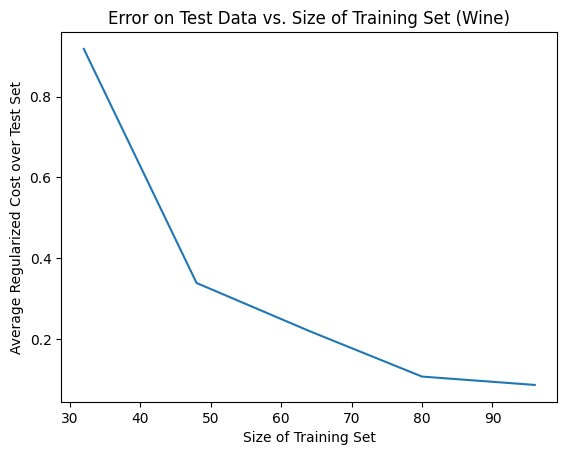

In [53]:
from matplotlib import pyplot as plt

def house_votes_curve():
    # Define network hyperparameters
    idealShape = [48, 8, 2]
    alpha = 1
    regParam = 1
    epsilon = 0.0001

    # Load data
    houseData = loadCSV(HOUSE_CSV, ',')

    # Get one hot encoded version of data set
    oneHotDf = pd.get_dummies(houseData)

    # From the entire data set, determine its class labels and features
    classLabels = {}
    features = set()
    index = 0
    for col in oneHotDf:
        if "class" in col:
            classLabels[col] = index
            index += 1
        else:
            features.add(col)
    
    # Generate stratified folds
    dataFolds = generate_stratified_folds(oneHotDf, classLabels)

    # Choose one set to be test set
    testData = dataFolds[0]
    testNoLabels = testData.loc[:, ~testData.columns.isin(classLabels)]

    # Test combining different folds
    numFolds = [2, 3, 4, 5, 6]
    errors = {}
    for num in numFolds:
        # Generate training set based on number of folds
        trainFolds = []
        for j in range(1, num + 1):
            trainFolds.append(dataFolds[j])
        trainData = pd.concat(trainFolds)

        # Create and train neural network
        nn = NeuralNetwork(
            idealShape, 
            trainData,
            classLabels,
            regParam=regParam,
            alpha=alpha,
            epsilon=epsilon
        )

        nn.train_network()

        # Compute cost over all test instances
        cost = nn.compute_error(testNoLabels)
        errors[len(trainData)] = cost
    
    print(errors)

    # Create plot
    x_axis = []
    y_axis = []
    for size in errors:
        x_axis.append(size)
        y_axis.append(errors[size])
    
    plt.plot(x_axis, y_axis)
    plt.title("Error on Test Data vs. Size of Training Set (House Votes)")
    plt.xlabel("Size of Training Set")
    plt.ylabel("Average Regularized Cost over Test Set")
    plt.show()

def wine_curve():
    # Define network hyperparameters
    idealShape = [13, 8, 3]
    alpha = 1
    regParam = 0
    epsilon = 0.0001

    wineData = loadCSV(WINE_CSV, '\t')
    
    # Set attribute value map
    attrTypes = {}
    for col in wineData.columns:
        if col != "class":
            attrTypes[col] = 'numerical'
    
    # Parse data types
    wineData = parseTypes(wineData, attrTypes)
    wineNoLabels = wineData.loc[:, wineData.columns!='class']
    
    # Normalize data set
    wineNormal = (wineNoLabels - wineNoLabels.min()) / (wineNoLabels.max() - wineNoLabels.min())
    wineNormal['class'] = wineData['class']

    # One hot encode wine data
    wineOneHot = pd.get_dummies(wineNormal)
    classLabels = {'class_1': 0, 'class_2': 1, 'class_3': 2}

    # Generate stratified folds
    dataFolds = generate_stratified_folds(wineOneHot, classLabels)

    # Choose one data set to be test set
    testData = dataFolds[0]
    testNoLabels = testData.loc[:, ~testData.columns.isin(classLabels)]

    # Test combining different folds
    numFolds = [2, 3, 4, 5, 6]
    errors = {}
    for num in numFolds:
        # Generate training set based on number of folds
        trainFolds = []
        for j in range(1, num + 1):
            trainFolds.append(dataFolds[j])
        trainData = pd.concat(trainFolds)

        # Create and train neural network
        nn = NeuralNetwork(
            idealShape, 
            trainData,
            classLabels,
            regParam=regParam,
            alpha=alpha,
            epsilon=epsilon
        )

        nn.train_network()

        # Compute cost over all test instances
        cost = nn.compute_error(testNoLabels)
        errors[len(trainData)] = cost
    
    print(errors)

    # Create plot
    x_axis = []
    y_axis = []
    for size in errors:
        x_axis.append(size)
        y_axis.append(errors[size])
    
    plt.plot(x_axis, y_axis)
    plt.title("Error on Test Data vs. Size of Training Set (Wine)")
    plt.xlabel("Size of Training Set")
    plt.ylabel("Average Regularized Cost over Test Set")
    plt.show()

wine_curve()